# Example of storing results to different format for ImageToTextV2

This notebook demonstrate pipeline for detect text using __ImageTextDetectorV2__ and text recognition using __ImageToTextV2__ on the image.

__ImageToTextV2__ support following output formats:
* OcrOutputFormat.TEXT - raw unformatted text
* OcrOutputFormat.FORMATTED_TEXT - text with preserved original formatting
* OcrOutputFormat.HOCR - [HOCR specification](http://kba.cloud/hocr-spec/1.2/#introduction)

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""


import os
if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license

## Initialization of spark session

In [2]:
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.2.1
Spark NLP version: 4.4.0
Spark NLP for Healthcare version: 4.3.0
Spark OCR version: 4.4.0rc1



# Read image and display it

In [3]:
import pkg_resources
import pyspark.sql.functions as f
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


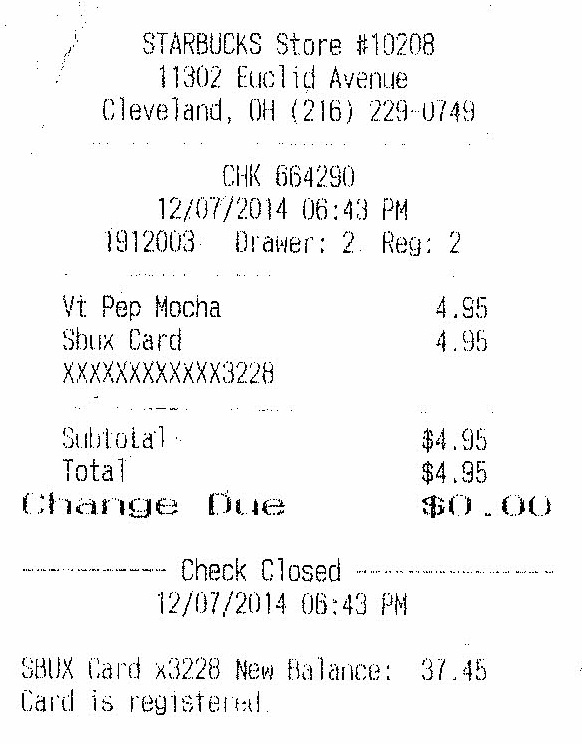

In [4]:
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_df = spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

# Define OCR Pipeline for detect and recognize text 

In [5]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image"]) \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False)
'''
ocr_formatted = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setOutputCol("text_formatted") \
    .setOutputFormat(OcrOutputFormat.FORMATTED_TEXT) \
    .setLineTolerance(0) \
    .setGroupImages(False) 
'''
draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


# Run pipeline and show results

### Show detected text on the original image


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


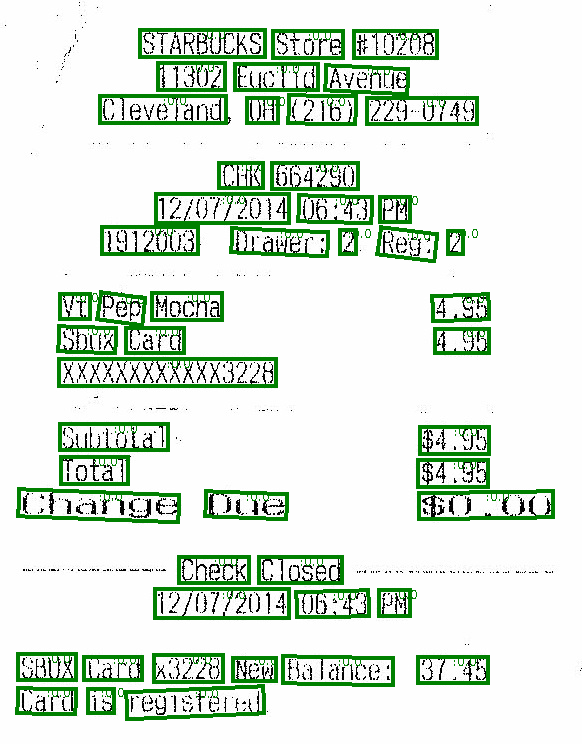

In [6]:
result = pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

### Unformatted results

In [7]:
print(("").join([x.text for x in result.select("text").collect()]))

STARBUCKS STORE #10208
11302 EUCLID AVENUE
CLEVELAND OH (216) 229-0749
CHK 664290
12/07/2014 06:43 PM
1912003 DRAWER: 2 REG: 2
VT PEP MOCHA 4.95
SBUX CARD 4.95
XXXXXXXXXXXX3228
SUBTOTAL $4.95
TOTAL $4.95
CHANGE DUE $0.00
CHECK CLOSED
12/07/2014 06:43 PM
SBUX CARD X3228 NEW BALANCE: 37.45
CARD IS REGISTERED


### Formatted results

In [8]:
# just modify this param
ocr = ocr.setOutputFormat(OcrOutputFormat.FORMATTED_TEXT) \
         .setOutputCol("text_formatted")
result = pipeline.transform(image_df).cache()

print(("").join([x.text_formatted for x in result.select("text_formatted").collect()]))

       STARBUCKS STORE #10208
      11302 EUCLID AVENUE
     CLEVELAND OH (216) 229-0749

        CHK 664290
       12/07/2014 06:43 PM
     1912003 DRAWER: 2 REG: 2

  VT PEP MOCHA  4.95
   SBUX CARD    4.95
     XXXXXXXXXXXX3228

    SUBTOTAL    $4.95
   TOTAL        $4.95
   CHANGE DUE    $0.00

       CHECK CLOSED
       12/07/2014 06:43 PM

 SBUX CARD X3228 NEW BALANCE: 37.45
 CARD IS REGISTERED


### Define pipeline for recognize text and get results in HOCR format
### Modify parameters and get results in HOCR format

In [9]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

# just modify this param
ocr = ocr.setOutputFormat(OcrOutputFormat.HOCR) \
         .setOutputCol("hocr")

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token") \

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(14)

hocr_pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    ocr,
    tokenizer,
    draw_annotations
])

### Draw HOCR to the original image


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


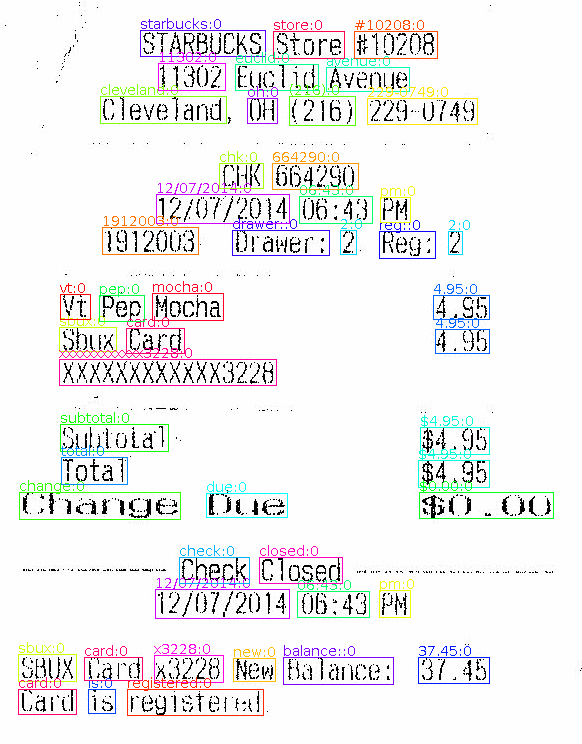

In [10]:
hocr_result = hocr_pipeline.transform(image_df).cache()
display_images(hocr_result, "image_with_annotations", width=1000)

### Show raw HOCR

In [11]:
print(hocr_result.select("hocr").collect()[0].hocr)

<div title="bbox 0 0 582 744" id="page_0" class="ocr_page"><div title="bbox 0 0 582 744" id="block_1" class="ocr_carea"><span title="bbox 140 30 265 56" id="word_1" class="ocrx_word">STARBUCKS</span><span title="bbox 273 31 344 58" id="word_2" class="ocrx_word">STORE</span><span title="bbox 354 31 437 58" id="word_3" class="ocrx_word">#10208</span><span title="bbox 158 63 225 90" id="word_4" class="ocrx_word">11302</span><span title="bbox 235 64 318 90" id="word_5" class="ocrx_word">EUCLID</span><span title="bbox 326 67 409 91" id="word_6" class="ocrx_word">AVENUE</span><span title="bbox 100 96 226 123" id="word_7" class="ocrx_word">CLEVELAND</span><span title="bbox 247 98 277 123" id="word_8" class="ocrx_word">OH</span><span title="bbox 289 96 355 125" id="word_9" class="ocrx_word">(216)</span><span title="bbox 367 98 477 124" id="word_10" class="ocrx_word">229-0749</span><span title="bbox 219 163 263 188" id="word_11" class="ocrx_word">CHK</span><span title="bbox 272 163 358 189" id=